Mushi
==
_All that the rain promises and more..._

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

API documentation can be viewed with
```python
help(mushi.η)
help(mushi.𝜇)
help(mushi.kSFS)
```

In [1]:
%matplotlib notebook
import mushi
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time
import msprime
%cd stdpopsim
from stdpopsim import homo_sapiens
%cd ../

/Users/williamdewitt/Desktop/repos/dement/stdpopsim
/Users/williamdewitt/Desktop/repos/dement


In [127]:
# plt.style.use('dark_background')

### Time grid

In [2]:
t = np.logspace(0, np.log10(3e4), 300)

### Demographic history $\eta(t)$ from the European population in Tennessen et al.

<IPython.core.display.Javascript object>


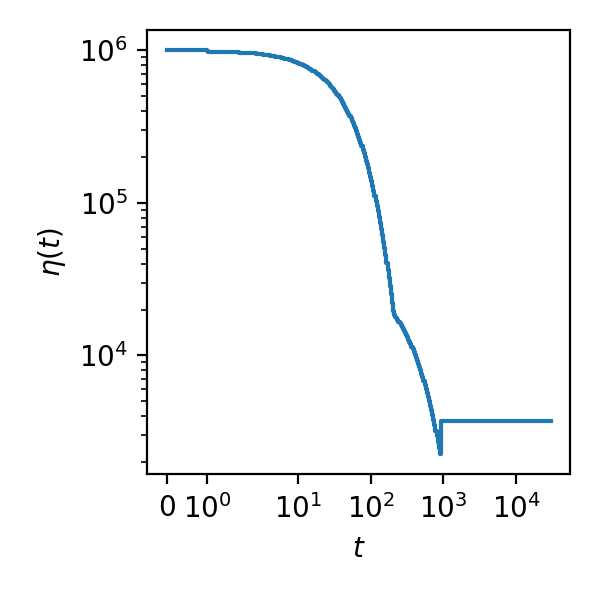

In [3]:
model = homo_sapiens.TennessenTwoPopOutOfAfrica()
dd = msprime.DemographyDebugger(Ne=model.default_population_size,
                                population_configurations=model.population_configurations,
                                demographic_events=model.demographic_events,
                                migration_matrix=model.migration_matrix)
y = 2 * dd.population_size_trajectory(np.concatenate(([0], t)))[:, 1]
η = mushi.η(t, y)

plt.figure(figsize=(3, 3))
η.plot()
plt.show()

### Mutation rate history $\mu(t)$
A 10 dimensional history with each mutation type a random mixture of 2 latent signatures:
- constant
- pulse
We will make the mutation rate low, so that the $k$-SFS is noisy and reconstruction of each of the 10 independently is difficult

In [67]:
tt = np.concatenate(([0], t))
flat = np.ones_like(tt)
# ramp = expit(-.01 * (tt - 50))
pulse = expit(0.03 * (tt - 80)) - expit(0.03 * (tt - 600))
cols = 20
Z = np.zeros((len(t) + 1, cols))
μ0 = 10
np.random.seed(1)
for col in range(cols):
    constant_weight = np.random.lognormal(0, 0.01)
    pulse_weight = np.random.exponential(.2)
    Z[:, col] = μ0 * (constant_weight * flat + pulse_weight * pulse)
μ = mushi.μ(t, Z)

<IPython.core.display.Javascript object>


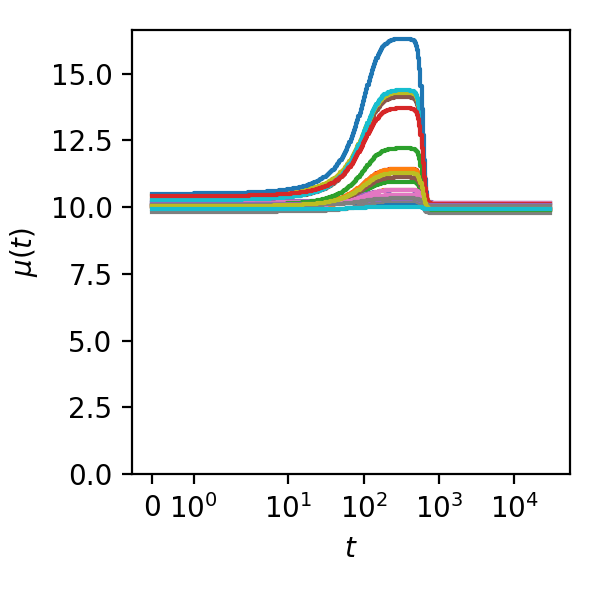

In [68]:
plt.figure(figsize=(3, 3))
μ.plot()
plt.ylim([0, None])
plt.show()

<IPython.core.display.Javascript object>


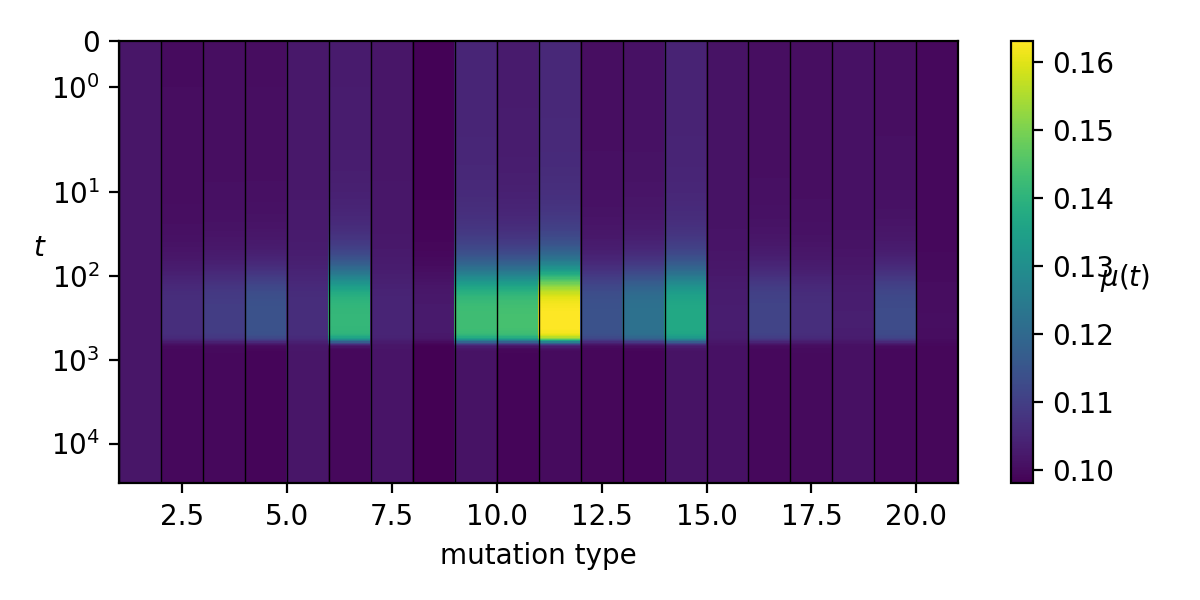

In [19]:
plt.figure(figsize=(6, 3))
μ.heatmap()
plt.show()

### Simulate a $k$-SFS under this history
We'll sample 200 haplotypes

<IPython.core.display.Javascript object>


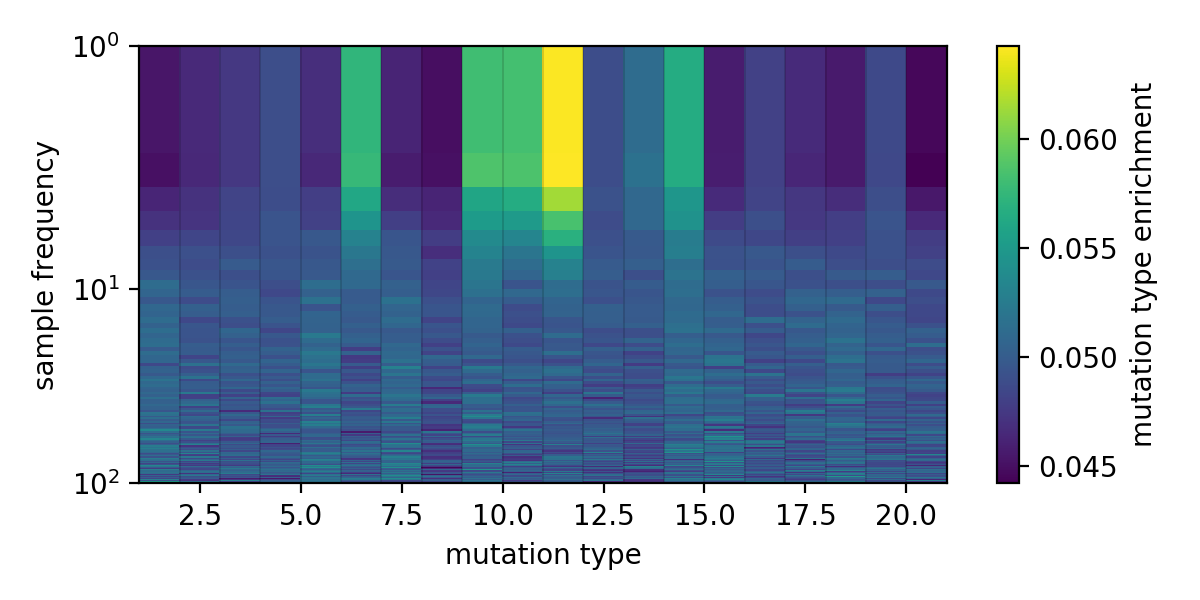

In [72]:
n = 100
sfs = mushi.kSFS(η, n=n)
sfs.simulate(μ, seed=1)

plt.figure(figsize=(6, 3))
sfs.heatmap()
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/sfs.pdf', transparent=True)

### TMRCA CDF

<IPython.core.display.Javascript object>


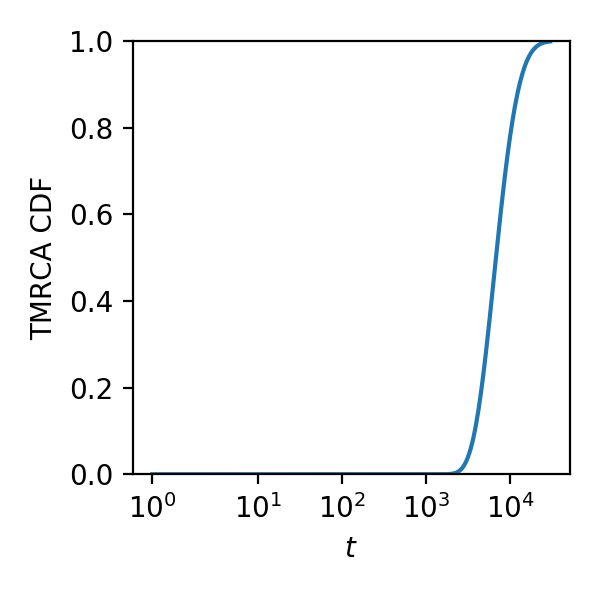

In [73]:
plt.figure(figsize=(3, 3))
plt.plot(η.change_points, sfs.tmrca_cdf())
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('symlog')
plt.tight_layout()
plt.show()

### Invert the $k$-SFS conditioned on $\eta(t)$ to get $\boldsymbol\mu(t)$
Accelerated proximal gradient descent

In [97]:
# time derivative regularization parameters
λ_tv = 1e1
α_tv = 0#0.99
# spectral regularization parameters
λ_r = 1e2
α_r = .9999999
γ = 0.8
max_iter = 10000
tol = 1e-10
bins = None
# hard Vs soft singular value thresholding
hard = True
# bins = np.logspace(0, np.log10(n), 5)
with np.errstate(all='raise'):
    μ_inferred = sfs.infer_μ(λ_tv=λ_tv, α_tv=α_tv, λ_r=λ_r, α_r=α_r, γ=γ, max_iter=max_iter, tol=tol, bins=bins, hard=hard)

relative change in loss function 2.3e-11 is within tolerance 1e-10 after 549 iterations


The inferred histories for each mutation type superimposed on the 3 underlying signatures

<IPython.core.display.Javascript object>


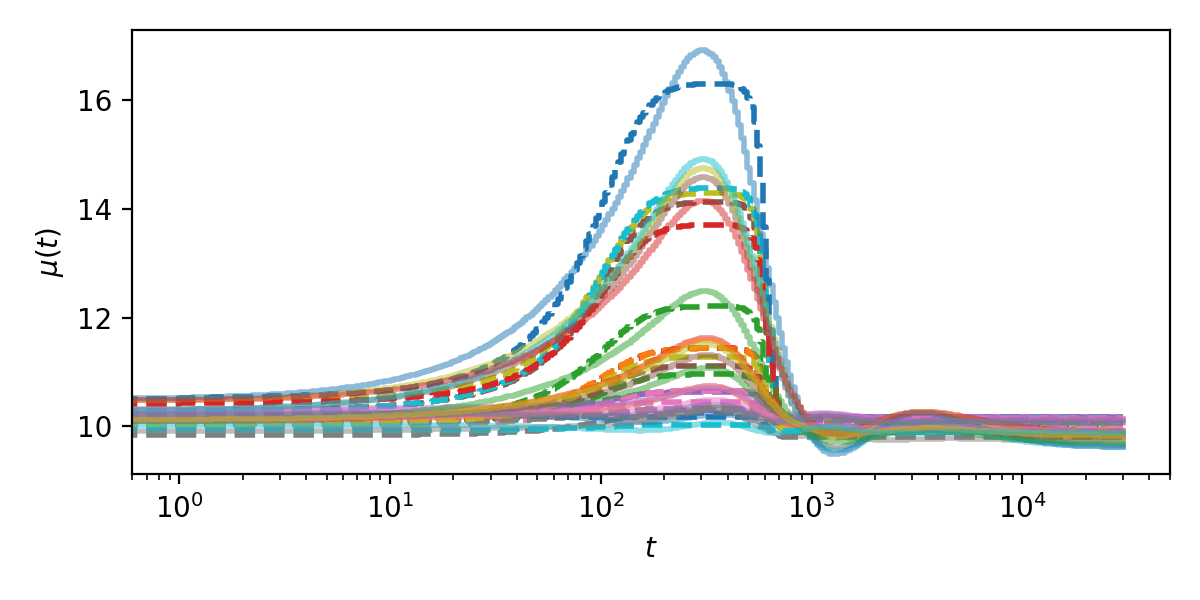

In [98]:
plt.figure(figsize=(6, 3))
μ.plot(ls='--', alpha=1, lw=2)
μ_inferred.plot(alpha=0.5, lw=2)
plt.ylabel('$μ(t)$')
plt.xscale('log')
plt.tight_layout()
plt.show()
# plt.savefig('/Users/williamdewitt/Downloads/mu.pdf', transparent=True)

Heatmap of the inferred mutation spectrum history

<IPython.core.display.Javascript object>


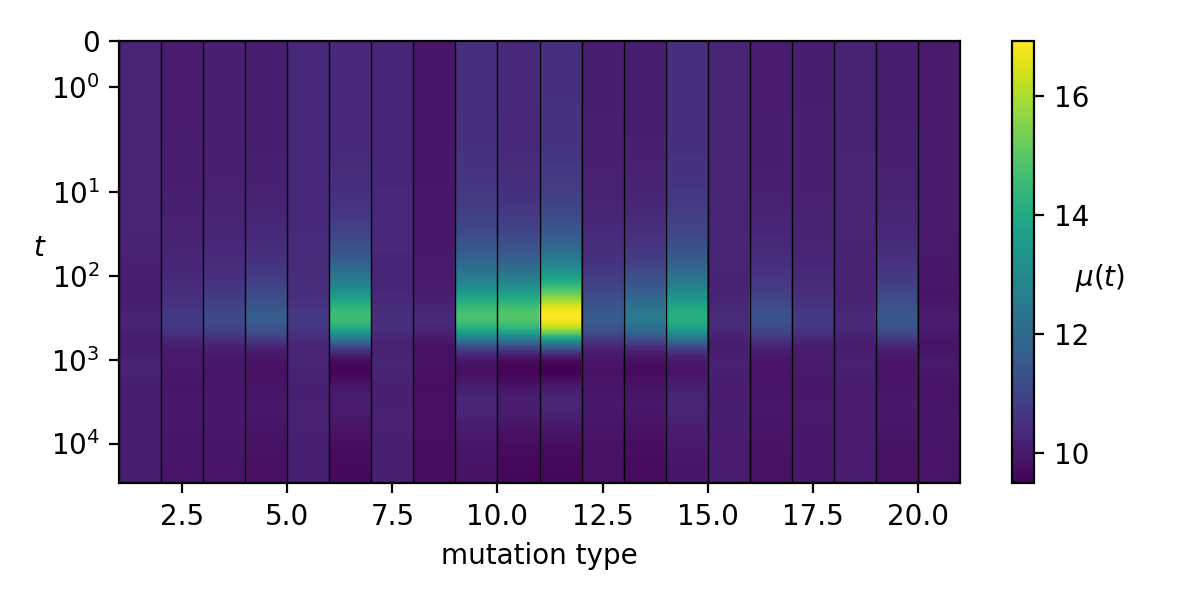

In [99]:
plt.figure(figsize=(6, 3))
μ_inferred.heatmap()
plt.show()

plot $\chi^2$ goodness of fit for each $k$-SFS matrix element, and compute $\chi^2$ goodness of fit test for the $k$-SFS matrix as a whole

<IPython.core.display.Javascript object>


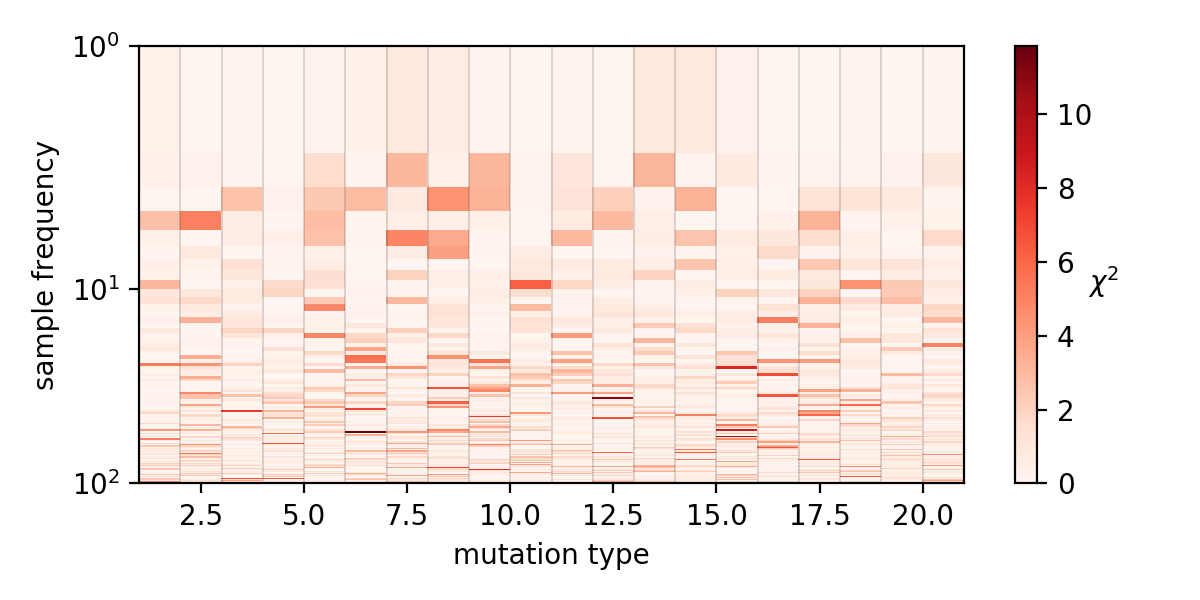

χ² goodness of fit 1852.5516942408726, p = 0.9802910284141316


In [100]:
plt.figure(figsize=(6, 3))
sfs.heatmap(μ_inferred)
plt.show()

An example column from each of the three signatures

<IPython.core.display.Javascript object>


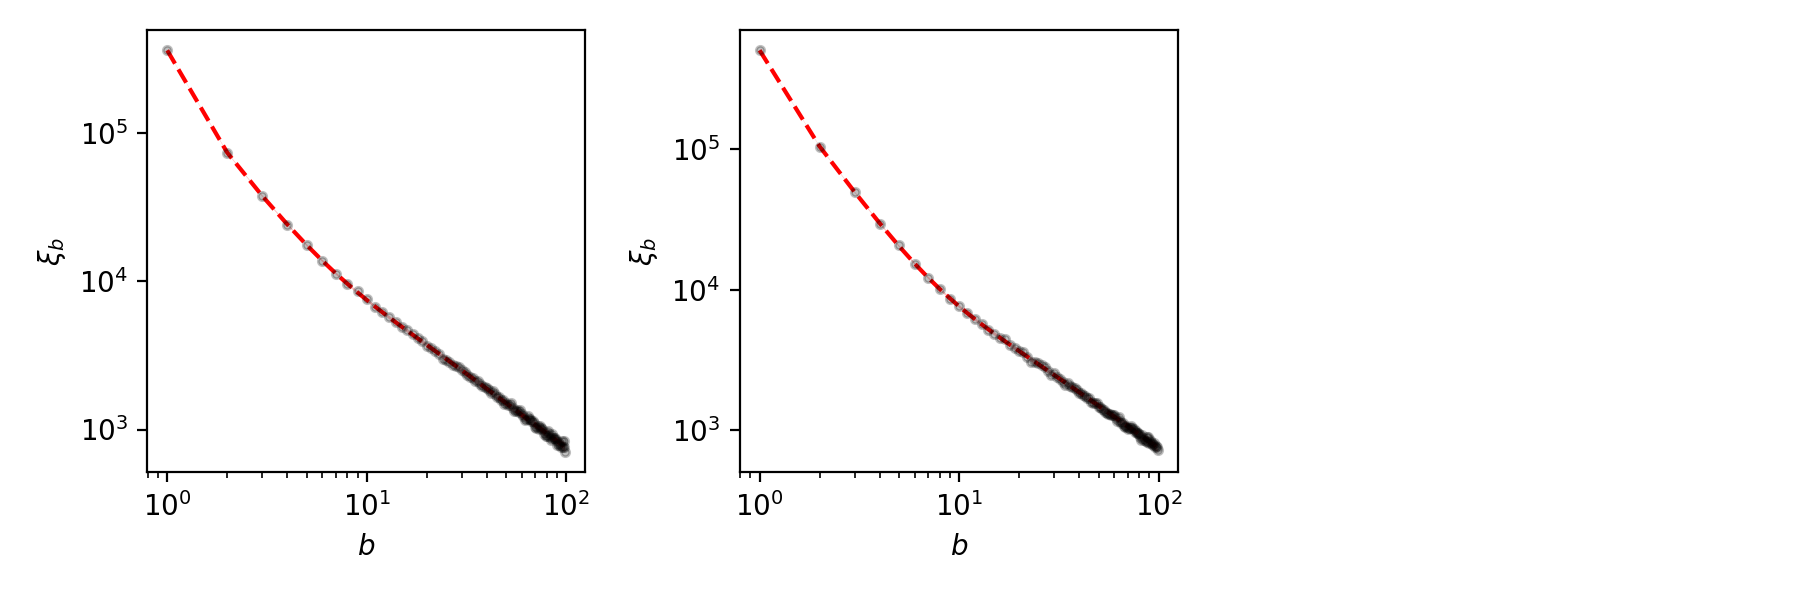

In [101]:
plt.figure(figsize=(9, 3))
for ct, i in enumerate((0, 10), 1):
    plt.subplot(1, 3, ct)
    sfs.plot(i, μ=μ_inferred, prf_quantiles=True)
plt.tight_layout()
plt.show()

### Singular value spectrum of $Z$

<IPython.core.display.Javascript object>


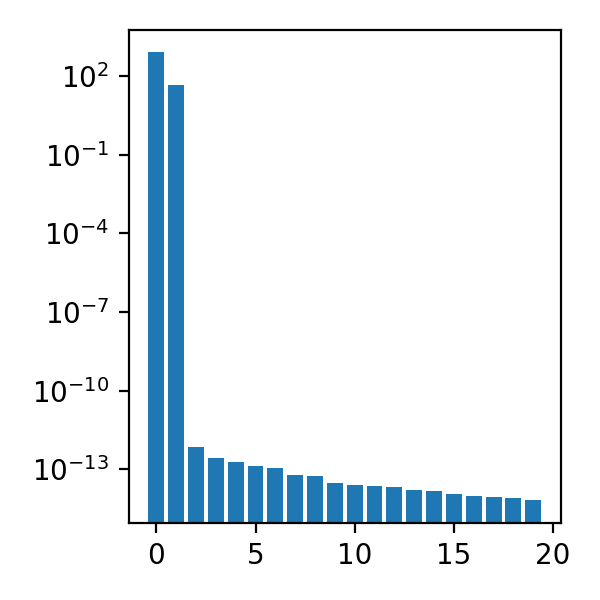

In [102]:
plt.figure(figsize=(3, 3))
plt.bar(range(μ_inferred.Z.shape[1]), np.linalg.svd(Z, compute_uv=False))
plt.yscale('log')
plt.tight_layout()
plt.show()